In [1]:
import inspect
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection

import pymc3 as pm
from pymc3 import sampling_jax

import theano.tensor as tt
import arviz as az

from pymc3 import modelcontext
from numpyro.infer import MCMC, NUTS

import os
import re
import warnings

from collections import defaultdict

xla_flags = os.getenv("XLA_FLAGS", "").lstrip("--")
xla_flags = re.sub(r"xla_force_host_platform_device_count=.+\s", "", xla_flags).split()
os.environ["XLA_FLAGS"] = " ".join(["--xla_force_host_platform_device_count={}".format(100)])

import jax
import theano.graph.fg

from theano.link.jax.jax_dispatch import jax_funcify

from xarray import Dataset

/Users/ajl573/.virtualenvs/base/lib/python3.8/site-packages/pymc3/sampling_jax.py:24: UserWarning: This module is experimental.
  warnings.warn("This module is experimental.")


In [2]:
pm.__version__

'3.11.2'

In [2]:
def _transform_samples(samples, model, keep_untransformed=False):

    # Find out which RVs we need to compute:
    free_rv_names = {x.name for x in model.free_RVs}
    unobserved_names = {x.name for x in model.unobserved_RVs}

    names_to_compute = unobserved_names - free_rv_names
    ops_to_compute = [x for x in model.unobserved_RVs if x.name in names_to_compute]

    # Create function graph for these:
    fgraph = theano.graph.fg.FunctionGraph(model.free_RVs, ops_to_compute)

    # Jaxify, which returns a list of functions, one for each op
    jax_fns = jax_funcify(fgraph)

    # Put together the inputs
    inputs = [samples[x.name] for x in model.free_RVs]

    for cur_op, cur_jax_fn in zip(ops_to_compute, jax_fns):

        # We need a function taking a single argument to run vmap, while the
        # jax_fn takes a list, so:
        result = jax.vmap(jax.vmap(cur_jax_fn))(*inputs)

        # Add to sample dict
        samples[cur_op.name] = result

    # Discard unwanted transformed variables, if desired:
    vars_to_keep = set(
        pm.util.get_default_varnames(list(samples.keys()), include_transformed=keep_untransformed)
    )
    samples = {x: y for x, y in samples.items() if x in vars_to_keep}

    return samples

def sample(
    draws=1000,
    tune=1000,
    chains=4,
    target_accept=0.8,
    random_seed=10,
    model=None,
    progress_bar=True,
    keep_untransformed=False,
):

    model = modelcontext(model)

    seed = jax.random.PRNGKey(random_seed)

    fgraph = theano.graph.fg.FunctionGraph(model.free_RVs, [model.logpt])
    fns = jax_funcify(fgraph)
    logp_fn_jax = fns[0]

    rv_names = [rv.name for rv in model.free_RVs]
    init_state = [model.test_point[rv_name] for rv_name in rv_names]
#     init_state = {rv_name: model.test_point[rv_name] for rv_name in rv_names}
    init_state_batched = jax.tree_map(lambda x: np.repeat(x[None, ...], chains, axis=0), init_state)
#     print(init_state_batched)
#     print(type(init_state_batched))
#     init_state_batched = dict(zip(rv_names, init_state_batched))
#     print(init_state_batched)

    @jax.jit
    def _sample(current_state, seed):
        step_size = jax.tree_map(jax.numpy.ones_like, init_state)
        nuts_kernel = NUTS(
            potential_fn=lambda x: -logp_fn_jax(*x),
#             potential_fn=lambda x: -logp_fn_jax(*x.values()),
            # model=model,
            target_accept_prob=target_accept,
            adapt_step_size=True,
            adapt_mass_matrix=True,
            dense_mass=False,
        )

        pmap_numpyro = MCMC(
            nuts_kernel,
            num_warmup=tune,
            num_samples=draws,
            num_chains=chains,
#             postprocess_fn=postprocess_fn,
            chain_method="parallel",
            progress_bar=progress_bar,
        )
        
#         return pmap_numpyro
        pmap_numpyro.run(seed, init_params=current_state, extra_fields=("num_steps",))
        return pmap_numpyro.get_samples(group_by_chain=True)
#         return pmap_numpyro
#         samples = pmap_numpyro.get_samples(group_by_chain=True)
#         leapfrogs_taken = pmap_numpyro.get_extra_fields(group_by_chain=True)["num_steps"]
#         return samples, leapfrogs_taken

    print("Compiling...")
    tic2 = pd.Timestamp.now()
    map_seed = jax.random.split(seed, chains)
#     mcmc_samples, leapfrogs_taken = _sample(init_state_batched, map_seed)
    mcmc = _sample(init_state_batched, map_seed)
#     mcmc_samples = mcmc.get_samples(group_by_chain=True)
#     posterior = {k: v for k, v in zip(rv_names, mcmc_samples)}
    
    tic3 = pd.Timestamp.now()
    
#     posterior = _transform_samples(posterior, model, keep_untransformed=keep_untransformed)
#     az_trace_ = az.from_dict(posterior=posterior)
    
#     az_trace = az.from_numpyro(mcmc)
#     az_trace.posterior = az_trace_.posterior

    # map_seed = jax.random.split(seed, chains)
    # mcmc_samples = _sample(init_state_batched, map_seed)
    # tic4 = pd.Timestamp.now()
    # print("Sampling time = ", tic4 - tic3)

#     posterior = {k: v for k, v in zip(rv_names, mcmc_samples)}
#     posterior = _transform_samples(posterior, model, keep_untransformed=keep_untransformed)
    tic4 = pd.Timestamp.now()

#     az_trace = az.from_dict(posterior=posterior)
    print("Compilation + sampling time = ", tic3 - tic2)
    print("Transformation time = ", tic4 - tic3)
    
#     az_trace = az.from_numpyro(mcmc)
#     return az_trace  # , leapfrogs_taken, tic3 - tic2
    return mcmc, fgraph, fns

In [3]:
track = pd.read_csv('../examples/data/modes.csv')
track.head()

,frac_age,delta_nu_fit,nu_max,nu_0_1,nu_0_2,nu_0_3,nu_0_4,nu_0_5,nu_0_6,nu_0_7,...,nu_0_32,nu_0_33,nu_0_34,nu_0_35,nu_0_36,nu_0_37,nu_0_38,nu_0_39,nu_0_40,surface_he4
0,0.000016,11.884045,150.680452,0.0,34.481794,49.329712,63.195077,75.913367,87.630758,99.483102,...,392.064627,403.710370,415.297909,426.924218,438.655667,450.550178,462.546781,474.658899,486.825847,0.239966
1,0.000017,12.140476,154.893200,0.0,35.203007,50.376320,64.548471,77.583389,89.569246,101.679667,...,400.620086,412.538305,424.386957,436.252351,448.212638,460.326691,472.558635,484.919720,497.325734,0.239967
2,0.000017,12.343045,158.238356,0.0,35.772049,51.202159,65.616199,78.900744,91.100159,103.413323,...,407.368711,419.505074,431.563921,443.619056,455.762984,468.048949,480.469626,493.018551,505.616340,0.239968
3,0.000018,12.503403,160.898485,0.0,36.222266,51.855582,66.460893,79.942765,92.312228,104.785371,...,412.708426,425.019262,437.245702,449.452226,461.742276,474.164224,486.734715,499.427290,512.179364,0.239969
4,0.000018,12.633487,163.061612,0.0,36.587368,52.385499,67.145867,80.787635,93.295718,105.898357,...,417.037759,429.491253,441.854064,454.184875,466.594022,479.127384,491.819429,504.626946,517.505773,0.239969


In [4]:
# profile = track.loc[track['frac_age'] < 0.5].iloc[-1]
profile = track.loc[600]

In [5]:
nu_index = [f'nu_0_{i}' for i in range(10, 30)]

def get_nu(profile):
    nu = profile[nu_index].to_numpy().astype(float)
    nu = nu[nu > 0.0]  # Values equal to zero correspond to no calculation
    return nu

nu = get_nu(profile)

In [6]:
# Scaling relation nu_max
numax = profile['nu_max']
print('numax ~', round(numax, 2), 'muHz')

# Delta_nu fit to radial modes about nu_max
dnu = profile['delta_nu_fit']
print('dnu ~', round(dnu, 2), 'muHz')

numax ~ 2853.19 muHz
dnu ~ 128.7 muHz


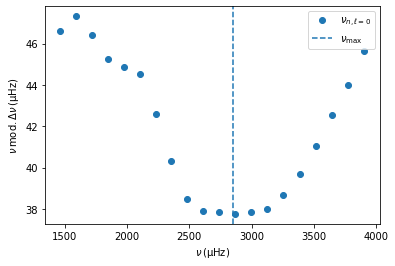

In [7]:
numod = nu % dnu

fig, ax = plt.subplots()

ax.plot(nu, numod, 'o', label=r'$\nu_{n,\ell = 0}$')
ax.axvline(numax, linestyle='--', label=r'$\nu_\mathrm{max}$')
ax.set_ylabel(r'$\nu\,\mathrm{mod.}\Delta\nu\,(\mathrm{\mu Hz})$')
ax.set_xlabel(r'$\nu\,(\mathrm{\mu Hz})$')

ax.legend()

In [8]:
def asy_background(n, epsilon, alpha, delta_nu, nu_max):
    n_max = nu_max / delta_nu - epsilon
    return delta_nu * (n + epsilon + 0.5 * alpha * (n - n_max)**2)

def he_amplitude(nu, b0, b1, lib=tt):
    return b0 * nu * lib.exp(- b1 * nu**2)

def he_glitch(nu, b0, b1, tau_he, phi_he, lib=tt):
    return he_amplitude(nu, b0, b1, lib=lib) * lib.sin(4 * np.pi * tau_he * nu + phi_he)

In [9]:
1/numax

0.00035048457232552424

In [10]:
n = np.arange(10, 30)

epsilon = 1.3
alpha = 0.001
b0 = 10/numax
b1 = 2/numax**2
tau_he = 0.0006
phi_he = np.pi-0.01

delta_nu = dnu
nu_max = numax - 100

glitch = he_glitch(nu, b0, b1, tau_he, phi_he, lib=np)
asy = asy_background(n, epsilon, alpha, delta_nu, nu_max)
model = asy + glitch

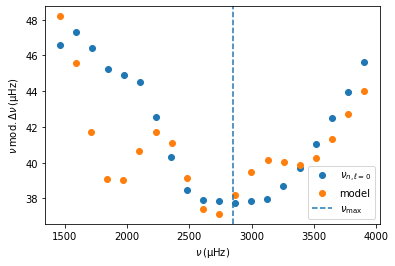

In [11]:
numod = nu % dnu
modelmod = model % dnu

fig, ax = plt.subplots()

ax.plot(nu, numod, 'o', label=r'$\nu_{n,\ell = 0}$')
ax.plot(model, modelmod, 'o', label=r'model')

ax.axvline(numax, linestyle='--', label=r'$\nu_\mathrm{max}$')
ax.set_ylabel(r'$\nu\,\mathrm{mod.}\Delta\nu\,(\mathrm{\mu Hz})$')
ax.set_xlabel(r'$\nu\,(\mathrm{\mu Hz})$')

ax.legend()

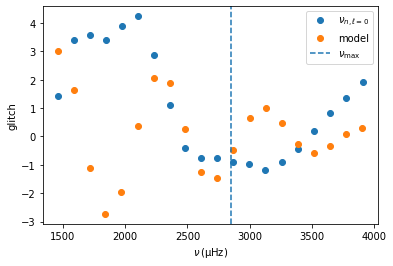

In [12]:
fig, ax = plt.subplots()

ax.plot(nu, nu - asy , 'o', label=r'$\nu_{n,\ell = 0}$')
ax.plot(model, glitch, 'o', label=r'model')

ax.axvline(numax, linestyle='--', label=r'$\nu_\mathrm{max}$')
ax.set_ylabel(r'glitch')
ax.set_xlabel(r'$\nu\,(\mathrm{\mu Hz})$')

ax.legend()

In [14]:
with pm.Model() as model_asy:
    
    epsilon = pm.Normal('epsilon', 1.3, 0.2)
    alpha = pm.Lognormal('alpha', tt.log(0.001), 1.0)
    delta_nu = pm.Normal('delta_nu', dnu, 1.0)
    nu_max = pm.Normal('nu_max', numax, numax*0.05)

    nu_err = pm.HalfNormal('nu_err', 0.1)

    nu_model = pm.Deterministic('nu_model', asy_background(n, epsilon, alpha, delta_nu, nu_max))
    
    nu_obs = pm.Normal('nu_obs', nu_model, nu_err, observed=nu)

In [98]:
with model_asy:
    trace_asy = sample(tune=2000, chains=10, target_accept=0.95, progress_bar=False)

[array([1.3, 1.3, 1.3, 1.3, 1.3, 1.3, 1.3, 1.3, 1.3, 1.3]), array([-6.90775528, -6.90775528, -6.90775528, -6.90775528, -6.90775528,
       -6.90775528, -6.90775528, -6.90775528, -6.90775528, -6.90775528]), array([128.69939436, 128.69939436, 128.69939436, 128.69939436,
       128.69939436, 128.69939436, 128.69939436, 128.69939436,
       128.69939436, 128.69939436]), array([2853.19263374, 2853.19263374, 2853.19263374, 2853.19263374,
       2853.19263374, 2853.19263374, 2853.19263374, 2853.19263374,
       2853.19263374, 2853.19263374]), array([-2.52837645, -2.52837645, -2.52837645, -2.52837645, -2.52837645,
       -2.52837645, -2.52837645, -2.52837645, -2.52837645, -2.52837645])]
{'epsilon': array([1.3, 1.3, 1.3, 1.3, 1.3, 1.3, 1.3, 1.3, 1.3, 1.3]), 'alpha_log__': array([-6.90775528, -6.90775528, -6.90775528, -6.90775528, -6.90775528,
       -6.90775528, -6.90775528, -6.90775528, -6.90775528, -6.90775528]), 'delta_nu': array([128.69939436, 128.69939436, 128.69939436, 128.69939436,
     

In [94]:
trace_asy._states

{'diverging': DeviceArray([[ True,  True,  True, ...,  True,  True,  True],
              [ True,  True,  True, ...,  True,  True,  True],
              [ True,  True,  True, ...,  True,  True,  True],
              ...,
              [ True,  True,  True, ...,  True,  True,  True],
              [ True,  True,  True, ...,  True,  True,  True],
              [ True,  True,  True, ...,  True,  True,  True]], dtype=bool),
 'num_steps': DeviceArray([[1, 1, 1, ..., 1, 1, 1],
              [1, 1, 1, ..., 1, 1, 1],
              [1, 1, 1, ..., 1, 1, 1],
              ...,
              [1, 1, 1, ..., 1, 1, 1],
              [1, 1, 1, ..., 1, 1, 1],
              [1, 1, 1, ..., 1, 1, 1]], dtype=int64),
 'z': {'alpha_log__': DeviceArray([[-6.90775528, -6.90775528, -6.90775528, ..., -6.90775528,
                -6.90775528, -6.90775528],
               [-6.90775528, -6.90775528, -6.90775528, ..., -6.90775528,
                -6.90775528, -6.90775528],
               [-6.90775528, -6.90775528, -

In [74]:
trace_asy.print_summary()


                    mean       std    median      5.0%     95.0%     n_eff     r_hat
   alpha_log__     -6.91      0.00     -6.91     -6.91     -6.91       nan       nan
      delta_nu    128.70      0.00    128.70    128.70    128.70      5.01      1.43
       epsilon      1.30      0.00      1.30      1.30      1.30      5.01      1.00
  nu_err_log__     -2.53      0.00     -2.53     -2.53     -2.53      5.01       inf
        nu_max   2853.19      0.00   2853.19   2853.19   2853.19      5.01      1.43

Number of divergences: 10000


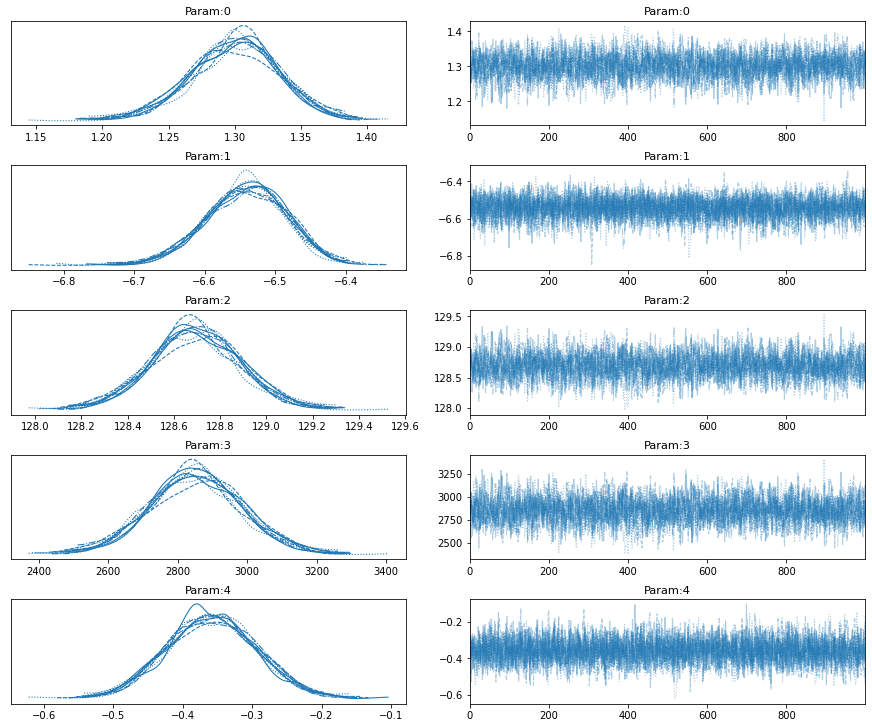

In [54]:
with model_asy:
    ax = az.plot_trace(trace_asy, compact=True)

In [37]:
with model_asy:
    df = az.summary(trace_asy)
df.head()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
epsilon,1.300,0.034,1.235,1.363,0.001,0.000,2940.0,3819.0,1.0
delta_nu,128.693,0.196,128.322,129.066,0.004,0.003,2936.0,3904.0,1.0
nu_max,2851.311,133.808,2599.816,3109.427,2.446,1.731,2987.0,4010.0,1.0
alpha,0.001,0.000,0.001,0.002,0.000,0.000,4490.0,4527.0,1.0
nu_err,0.700,0.046,0.618,0.788,0.001,0.000,5053.0,4807.0,1.0


In [38]:
trace_asy

Inference data with groups:
	> posterior

In [20]:
nu_model = trace_asy.posterior['nu_model'].values

In [21]:
nu_model = nu_model.reshape(
        (nu_model.shape[0]*nu_model.shape[1],
         nu_model.shape[2])
    )
nu_model.shape

(10000, 20)

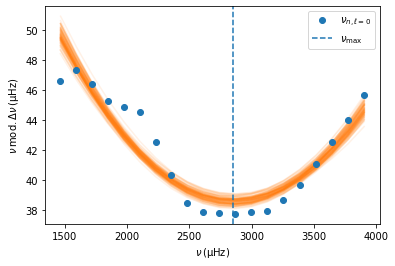

In [22]:
n_samples = 100
samples = np.random.choice(np.arange(nu_model.shape[0]), size=n_samples)

fig, ax = plt.subplots()

ax.plot(nu_model[samples].T, nu_model[samples].T % dnu, '-', color='C1', alpha=0.1)
ax.plot(nu, nu % dnu, 'o', label=r'$\nu_{n,\ell = 0}$')

ax.axvline(numax, linestyle='--', label=r'$\nu_\mathrm{max}$')
ax.set_ylabel(r'$\nu\,\mathrm{mod.}\Delta\nu\,(\mathrm{\mu Hz})$')
ax.set_xlabel(r'$\nu\,(\mathrm{\mu Hz})$')

ax.legend()

In [15]:
with pm.Model() as model_glitch:
    
    epsilon = pm.Normal('epsilon', 1.3, 0.2)
    alpha = pm.Lognormal('alpha', np.log(1e-3), 1.0)
    delta_nu = pm.Normal('delta_nu', dnu, 1.0)
    nu_max = pm.Normal('nu_max', numax, numax*0.05)
    
    b0 = pm.Lognormal('b0', np.log(1/numax), 1.0)
    b1 = pm.Lognormal('b1', np.log(1/numax**2), 1.0)
    
    tau = pm.Lognormal('tau', tt.log(0.0005), 0.5)

    phi = pm.VonMises('phi', 0.0, 0.1)

    nu_err = pm.HalfNormal('nu_err', 0.1)
    
#     nu_asy = pm.Deterministic('nu_asy', asy_background(n, epsilon, alpha, delta_nu, nu_max))
    nu_asy = asy_background(n, epsilon, alpha, delta_nu, nu_max)
    
#     nu_glitch = pm.Deterministic('nu_glitch', he_glitch(nu_asy, b0, b1, tau, phi))
    nu_glitch = he_glitch(nu_asy, b0, b1, tau, phi)
    
#     nu_model = pm.Deterministic('nu_model', nu_asy + nu_glitch)
    nu_model = nu_asy + nu_glitch
    
    nu_obs = pm.Normal('nu_obs', nu_model, nu_err, observed=nu)

In [29]:
with model_glitch:
    trace_glitch = sampling_jax.sample_numpyro_nuts(tune=2000, chains=10, target_accept=0.95, progress_bar=False)

Compiling...
Compilation + sampling time =  0 days 00:00:16.547548
Transformation time =  0 days 00:00:00.028293


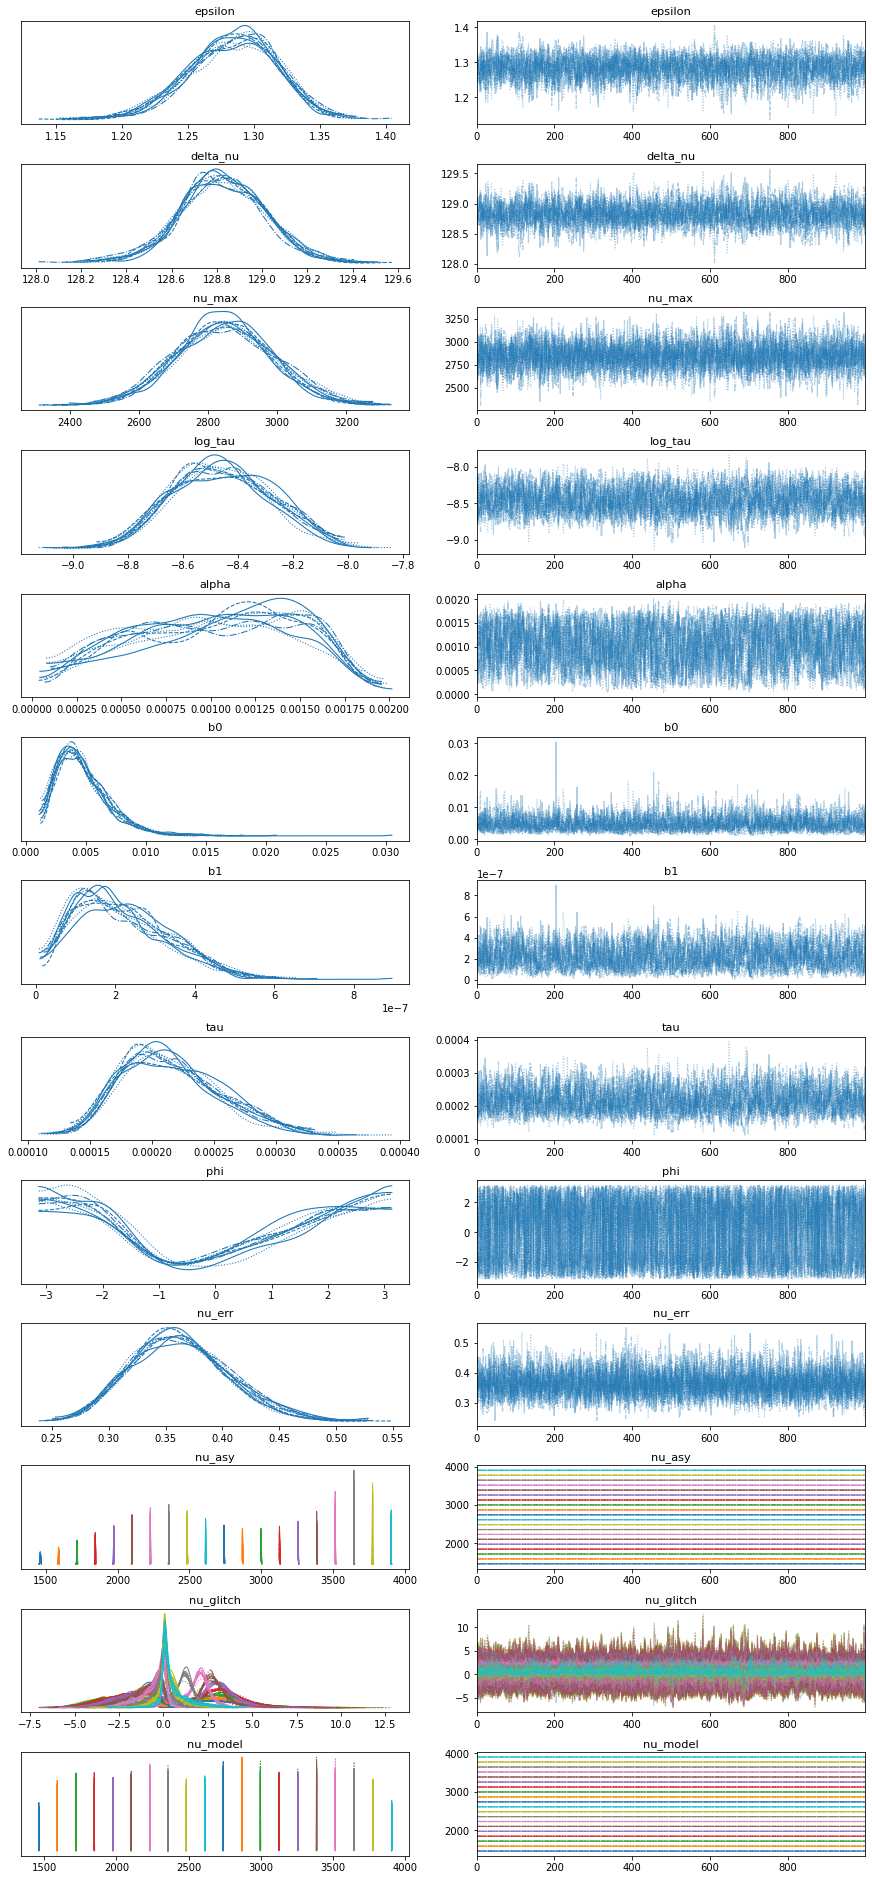

In [25]:
with model_glitch:
    ax = az.plot_trace(trace_glitch, compact=True)

$$\tau \sim \nu_\max^{-0.95}$$

$$\log(\tau) \sim -0.95 * \log(\nu_\max)$$

In [26]:
nu_glitch = trace_glitch.posterior['nu_glitch'].values

In [27]:
nu_glitch = nu_glitch.reshape(
        (nu_glitch.shape[0]*nu_glitch.shape[1],
         nu_glitch.shape[2])
    )
nu_glitch.shape

(10000, 20)

In [28]:
nu_model = trace_glitch.posterior['nu_model'].values

In [29]:
nu_model = nu_model.reshape(
        (nu_model.shape[0]*nu_model.shape[1],
         nu_model.shape[2])
    )
nu_model.shape

(10000, 20)

In [101]:
nu_asy = trace_glitch.posterior['nu_asy'].values

In [107]:
nu_asy = nu_asy.reshape(
        (nu_asy.shape[0]*nu_asy.shape[1],
         nu_asy.shape[2])
    )
nu_asy.shape

(10000, 20)

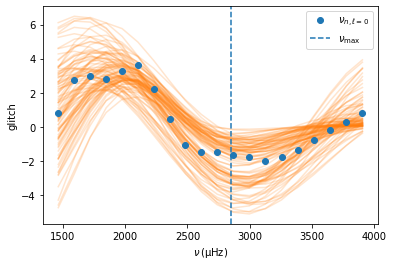

In [108]:
n_samples = 100
samples = np.random.choice(np.arange(nu_model.shape[0]), size=n_samples)

fig, ax = plt.subplots()

ax.plot(nu_model[samples].T, nu_glitch[samples].T, '-', color='C1', alpha=0.2)
ax.plot(nu, nu - nu_asy.mean(axis=0) , 'o', label=r'$\nu_{n,\ell = 0}$')

ax.axvline(numax, linestyle='--', label=r'$\nu_\mathrm{max}$')
ax.set_ylabel(r'glitch')
ax.set_xlabel(r'$\nu\,(\mathrm{\mu Hz})$')

ax.legend()

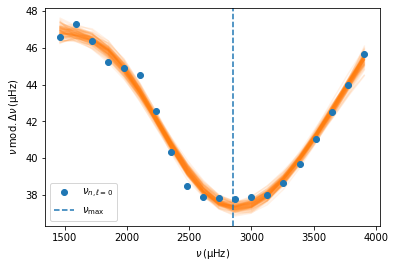

In [31]:
fig, ax = plt.subplots()

ax.plot(nu_model[samples].T, nu_model[samples].T % dnu, '-', color='C1', alpha=0.1)
ax.plot(nu, nu % dnu, 'o', label=r'$\nu_{n,\ell = 0}$')

ax.axvline(numax, linestyle='--', label=r'$\nu_\mathrm{max}$')
ax.set_ylabel(r'$\nu\,\mathrm{mod.}\Delta\nu\,(\mathrm{\mu Hz})$')
ax.set_xlabel(r'$\nu\,(\mathrm{\mu Hz})$')

ax.legend()

## Model He + BCZ glitch

In [13]:
def cz_amplitude(nu, c0):
    return c0 / nu**2

def cz_glitch(nu, c0, tau, phi, lib=tt):
    return cz_amplitude(nu, c0) * lib.sin(4 * np.pi * tau * nu + phi)

In [14]:
def glitch(nu, tau, phi):
    return tt.sin(4 * np.pi * tau * nu + phi)

In [15]:
with pm.Model() as model_glitch_hecz:
    
    # Asymptotic background
    epsilon = pm.Normal('epsilon', 1.3, 0.2)
    alpha = pm.Lognormal('alpha', np.log(1e-3), 1.0)
    delta_nu = pm.Normal('delta_nu', dnu, 1.0)
    nu_max = pm.Normal('nu_max', numax, numax*0.05)
    
    # He glitch
    b0 = pm.Lognormal('b0', np.log(1/numax), 1.0)
    b1 = pm.Lognormal('b1', np.log(1/numax**2), 1.0)
    tau_he = pm.Lognormal('tau_he', np.log(0.0005), 0.8)
    phi_he = pm.VonMises('phi_he', 0.0, 0.1)
    
    
    # BCZ glitch
    c0 = pm.Lognormal('c0', np.log(numax**2), 1.0)
    tau_cz = pm.Lognormal('tau_cz', tt.log(0.001), 0.8)
    phi_cz = pm.VonMises('phi_cz', 0.0, 0.1)
    
    delta_tau_logp = pm.Lognormal.dist(np.log(0.001), 0.8).logp(tau_cz - tau_he)
    delta_tau = pm.Potential('delta_tau', delta_tau_logp)
    
    nu_err = pm.HalfNormal('nu_err', 0.1)
    
    nu_asy = pm.Deterministic('nu_asy', asy_background(n, epsilon, alpha, delta_nu, nu_max))

    amp_he = pm.Deterministic('amp_he', he_amplitude(nu_asy, b0, b1))
    amp_cz = pm.Deterministic('amp_cz', cz_amplitude(nu_asy, c0))
    
#     delta_amp_logp = pm.Lognormal.dist(np.log(0.1), 0.5).logp(amp_cz/amp_he)
#     delta_amp = pm.Potential('delta_amp', delta_amp_logp)
    
#     dnu_he = pm.Deterministic('dnu_he', he_glitch(nu_asy, b0, b1, tau_he, phi_he))
#     dnu_cz = pm.Deterministic('dnu_cz', cz_glitch(nu_asy, c0, tau_cz, phi_cz))
    
    dnu_he = pm.Deterministic('dnu_he', amp_he * glitch(nu_asy, tau_he, phi_he))
    dnu_cz = pm.Deterministic('dnu_cz', amp_cz * glitch(nu_asy, tau_cz, phi_cz))

    nu_model = pm.Deterministic('nu_model', nu_asy + dnu_he + dnu_cz)
    
    nu_obs = pm.Normal('nu_obs', nu_model, nu_err, observed=nu)

In [16]:
with model_glitch_hecz:
    trace_glitch_hecz = sampling_jax.sample_numpyro_nuts(tune=2000, chains=10, target_accept=0.95)
#     trace_glitch_hecz = sample(tune=2000, chains=10, target_accept=0.95)

Compiling...


/Users/ajl573/.virtualenvs/base/lib/python3.8/site-packages/jax/interpreters/xla.py:682: UserWarning: The jitted function _sample includes a pmap. Using jit-of-pmap can lead to inefficient data movement, as the outer jit does not preserve sharded data representations and instead collects input and output arrays onto a single device. Consider removing the outer jit unless you know what you're doing. See https://github.com/google/jax/issues/2926.
  warn(f"The jitted function {fun.__name__} includes a pmap. Using "


Compilation + sampling time =  0 days 00:00:22.329958
Transformation time =  0 days 00:03:27.528294


In [18]:
# trace_glitch_hecz, fgraph, fns = trace_glitch_hecz

In [17]:
trace_glitch_hecz

Inference data with groups:
	> posterior

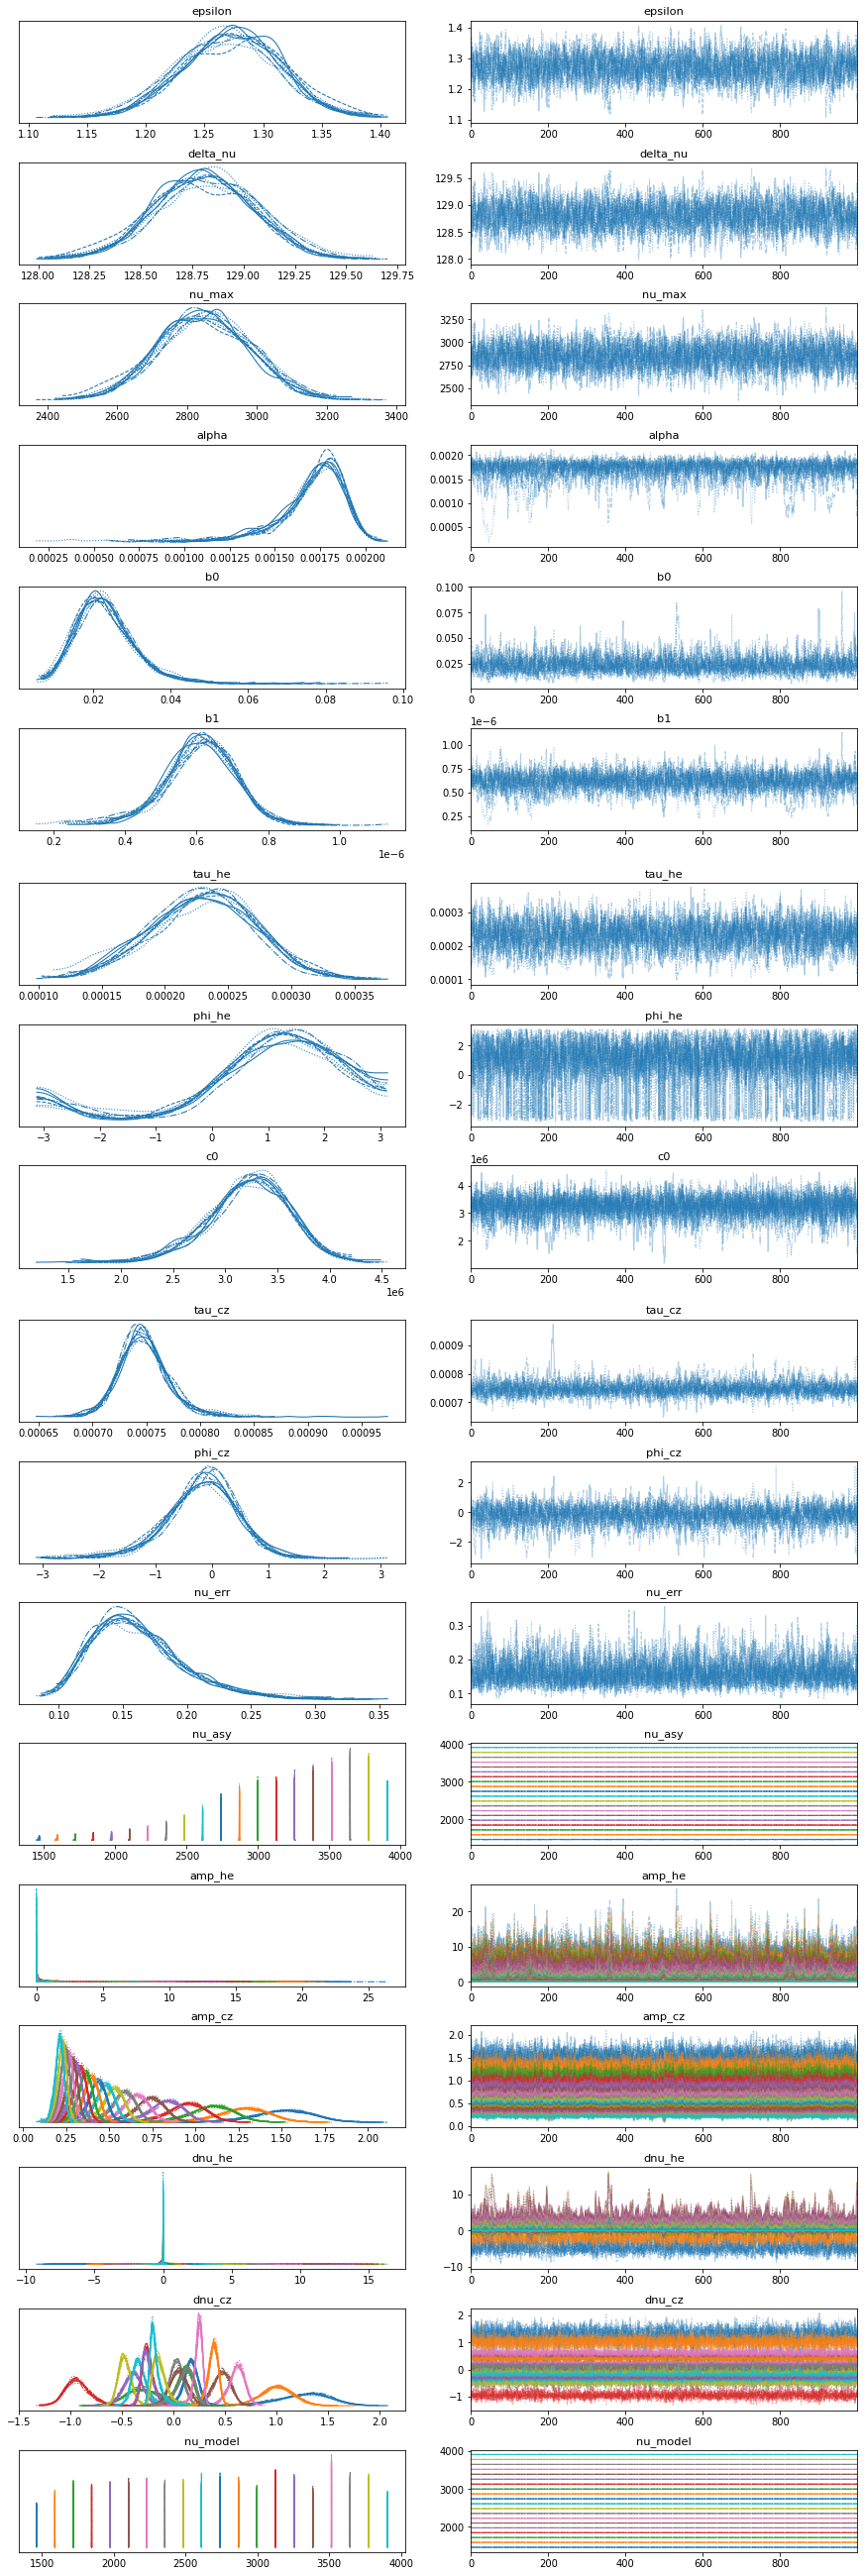

In [83]:
with model_glitch_hecz:
    ax = az.plot_trace(trace_glitch_hecz, compact=True)

$$\tau \sim \nu_\max^{-0.95}$$

$$\log(\tau) \sim -0.95 * \log(\nu_\max)$$

In [94]:
dnu_he = trace_glitch_hecz.posterior['dnu_he'].values
dnu_cz = trace_glitch_hecz.posterior['dnu_cz'].values
nu_glitch_hecz = dnu_he + dnu_cz

In [95]:
nu_glitch_hecz = nu_glitch_hecz.reshape(
        (nu_glitch_hecz.shape[0]*nu_glitch_hecz.shape[1],
         nu_glitch_hecz.shape[2])
    )
nu_glitch_hecz.shape

(10000, 20)

In [96]:
nu_model_hecz = trace_glitch_hecz.posterior['nu_model'].values

In [97]:
nu_model_hecz = nu_model_hecz.reshape(
        (nu_model_hecz.shape[0]*nu_model_hecz.shape[1],
         nu_model_hecz.shape[2])
    )
nu_model_hecz.shape

(10000, 20)

In [114]:
nu_asy_hecz = trace_glitch_hecz.posterior['nu_asy'].values

In [115]:
nu_asy_hecz = nu_asy_hecz.reshape(
        (nu_asy_hecz.shape[0]*nu_asy_hecz.shape[1],
         nu_asy_hecz.shape[2])
    )
nu_asy_hecz.shape

(10000, 20)

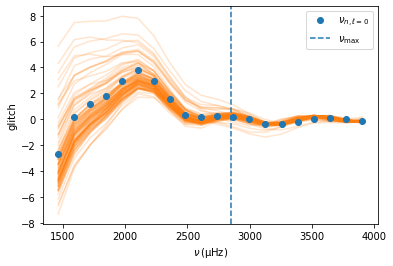

In [116]:
n_samples = 100
samples = np.random.choice(np.arange(nu_model_hecz.shape[0]), size=n_samples)

fig, ax = plt.subplots()

ax.plot(nu_model_hecz[samples].T, nu_glitch_hecz[samples].T, '-', color='C1', alpha=0.2)
ax.plot(nu, nu - nu_asy_hecz.mean(axis=0), 'o', label=r'$\nu_{n,\ell = 0}$')

ax.axvline(numax, linestyle='--', label=r'$\nu_\mathrm{max}$')
ax.set_ylabel(r'glitch')
ax.set_xlabel(r'$\nu\,(\mathrm{\mu Hz})$')

ax.legend()

In [120]:
post = trace_glitch_hecz.posterior

In [135]:
he_args = post[['b0', 'b1', 'tau_he', 'phi_he']].to_dataframe()
cz_args = post[['c0', 'tau_cz', 'phi_cz']].to_dataframe()

In [138]:
he_args.to_numpy().shape

(10000, 4)

In [159]:
n_range = 500
nu_range = np.linspace(nu[0], nu[-1], n_range)

dnu_he = he_glitch(nu_range[:, np.newaxis], *he_args.to_numpy().T, lib=np)
dnu_cz = cz_glitch(nu_range[:, np.newaxis], *cz_args.to_numpy().T, lib=np)

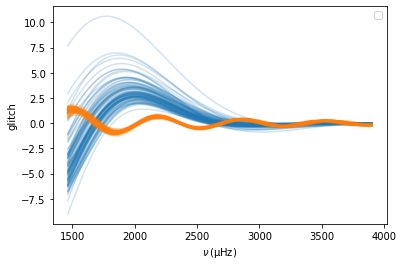

In [163]:
n_samples = 100
samples = np.random.choice(np.arange(dnu_he.shape[-1]), size=n_samples)

fig, ax = plt.subplots()

ax.plot(nu_range, dnu_he[:, samples], '-', color='C0', alpha=0.2)
ax.plot(nu_range, dnu_cz[:, samples], '-', color='C1', alpha=0.2)

ax.set_ylabel(r'glitch')
ax.set_xlabel(r'$\nu\,(\mathrm{\mu Hz})$')

In [165]:
nu_asy_hecz.shape

(10000, 20)

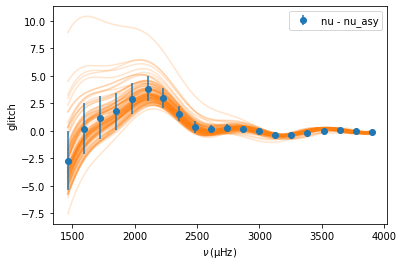

In [172]:
fig, ax = plt.subplots()

ax.plot(nu_range, dnu_he[:, samples] + dnu_cz[:, samples], '-', color='C1', alpha=0.2)
ax.errorbar(nu, nu - nu_asy_hecz.mean(axis=0), yerr=nu_asy_hecz.std(axis=0), fmt='o', zorder=10, label='nu - nu_asy')

ax.set_ylabel(r'glitch')
ax.set_xlabel(r'$\nu\,(\mathrm{\mu Hz})$')

ax.legend()

In [190]:
glitch = (dnu_he + dnu_cz)
glitch_upper = np.quantile(glitch, .84, axis=1)
glitch_median = np.median(glitch, axis=1)
glitch_lower = np.quantile(glitch, .16, axis=1)


In [211]:
nu_asy_med = np.median(nu_asy_hecz, axis=0)
nu_asy_err = [nu_asy_med - np.quantile(nu_asy_hecz, .16, axis=0), 
              np.quantile(nu_asy_hecz, .84, axis=0) - nu_asy_med]

In [222]:
nu_asy_err[::-1]  # Because we plot nu - nu_asy we flip the errors

[array([1.50807542, 1.30011661, 1.09774245, 0.91959133, 0.7604072 ,
        0.6145763 , 0.48654685, 0.36748345, 0.27405285, 0.2037971 ,
        0.15770026, 0.13995331, 0.14553639, 0.15061752, 0.15246011,
        0.14397077, 0.12071187, 0.09798338, 0.09082011, 0.1250745 ]),
 array([2.66971374, 2.3097068 , 1.98417111, 1.68066289, 1.39915686,
        1.1446304 , 0.9111904 , 0.7039612 , 0.524356  , 0.37585095,
        0.25879598, 0.17054608, 0.1263931 , 0.11147041, 0.10465445,
        0.09721008, 0.08611174, 0.07717655, 0.09228941, 0.14711508])]

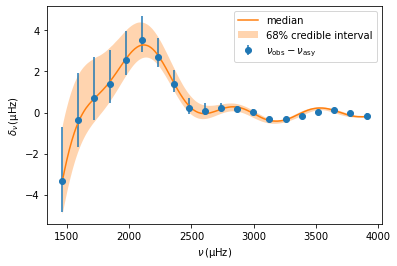

In [227]:
fig, ax = plt.subplots()

ax.errorbar(nu, nu - nu_asy_med, yerr=nu_asy_err[::-1], fmt='o', label=r'$\nu_\mathrm{obs} - \nu_\mathrm{asy}$')

ax.plot(nu_range, glitch_median, '-', color='C1', label='median')
ax.fill_between(nu_range, glitch_lower, glitch_upper, color='C1', alpha=0.33, linewidth=0, label='68% credible interval')

ax.set_ylabel(r'$\delta_\nu\,(\mathrm{\mu Hz})$')
ax.set_xlabel(r'$\nu\,(\mathrm{\mu Hz})$')

ax.legend()

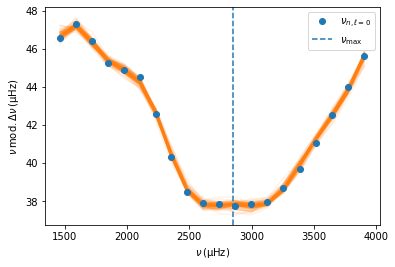

In [99]:
fig, ax = plt.subplots()

ax.plot(nu_model_hecz[samples].T, nu_model_hecz[samples].T % dnu, '-', color='C1', alpha=0.1)
ax.plot(nu, nu % dnu, 'o', label=r'$\nu_{n,\ell = 0}$')

ax.axvline(numax, linestyle='--', label=r'$\nu_\mathrm{max}$')
ax.set_ylabel(r'$\nu\,\mathrm{mod.}\Delta\nu\,(\mathrm{\mu Hz})$')
ax.set_xlabel(r'$\nu\,(\mathrm{\mu Hz})$')

ax.legend()